<a href="https://colab.research.google.com/github/Elshraby/GradProj4/blob/main/18_June_Claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Vertical Axis Wind Turbine (VAWT) Surrogate Model using PyTorch
# Optimized for Google Colab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
class VAWTDataProcessor:
    """Handles data loading, preprocessing and feature engineering for VAWT dataset"""

    def __init__(self):
        self.preprocessor = None
        self.feature_names = None
        self.categorical_features = ['Airfoil']
        self.numerical_features = [
            'Number of Blades', 'Cord Length', 'Height', 'Diameter',
            'Pitch Angle', 'Freestream Velocity', 'Tip Speed Ratio'
        ]
        self.target = 'Power Coefficient'

    def load_and_preprocess_data(self, file_path):
        """Load CSV data and perform preprocessing"""
        print("Loading data...")
        df = pd.read_csv(file_path)
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")

        # Check for missing values
        if df.isnull().sum().any():
            print("Warning: Missing values detected!")
            print(df.isnull().sum())

        # Create design groups (constant parameters except TSR)
        group_cols = [col for col in self.numerical_features if col != 'Tip Speed Ratio'] + self.categorical_features
        df['Design_ID'] = df[group_cols].astype(str).agg('-'.join, axis=1)

        print(f"Number of unique designs: {df['Design_ID'].nunique()}")
        print(f"Average data points per design: {len(df) / df['Design_ID'].nunique():.1f}")

        # Prepare features and target
        X = df[self.categorical_features + self.numerical_features]
        y = df[self.target]

        # Create preprocessing pipeline
        self.preprocessor = ColumnTransformer([
            ('num', StandardScaler(), self.numerical_features),
            # Changed 'sparse=False' to 'sparse_output=False' for compatibility with newer scikit-learn versions
            ('cat', OneHotEncoder(sparse_output=False, drop=None), self.categorical_features)
        ])

        print("Preprocessing features...")
        X_processed = self.preprocessor.fit_transform(X)

        # Store feature names for later use
        num_feature_names = self.numerical_features
        cat_feature_names = self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.categorical_features)
        self.feature_names = list(num_feature_names) + list(cat_feature_names)

        print(f"Processed feature shape: {X_processed.shape}")
        print(f"Target range: [{y.min():.3f}, {y.max():.3f}]")

        return X_processed, y.values, df

    def visualize_data_distribution(self, df):
        """Create comprehensive data visualizations"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('VAWT Dataset Analysis', fontsize=16)

        # Target distribution
        axes[0, 0].hist(df[self.target], bins=50, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Power Coefficient Distribution')
        axes[0, 0].set_xlabel('Cp')
        axes[0, 0].set_ylabel('Frequency')

        # TSR vs Cp scatter
        sample_designs = df['Design_ID'].drop_duplicates().sample(min(10, df['Design_ID'].nunique()), random_state=42)
        for i, design in enumerate(sample_designs):
            subset = df[df['Design_ID'] == design].sort_values('Tip Speed Ratio')
            axes[0, 1].plot(subset['Tip Speed Ratio'], subset[self.target],
                           alpha=0.7, linewidth=2, label=f'Design {i+1}')
        axes[0, 1].set_title('Cp vs Tip Speed Ratio (Sample Designs)')
        axes[0, 1].set_xlabel('Tip Speed Ratio')
        axes[0, 1].set_ylabel('Power Coefficient (Cp)')
        axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0, 1].grid(True, alpha=0.3)

        # Airfoil distribution
        airfoil_counts = df['Airfoil'].value_counts()
        axes[0, 2].pie(airfoil_counts.values, labels=airfoil_counts.index, autopct='%1.1f%%')
        axes[0, 2].set_title('Airfoil Distribution')

        # Correlation heatmap for numerical features
        numerical_df = df[self.numerical_features + [self.target]]
        corr_matrix = numerical_df.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
        axes[1, 0].set_title('Feature Correlation Matrix')

        # Number of blades distribution
        axes[1, 1].hist(df['Number of Blades'], bins=20, alpha=0.7, edgecolor='black')
        axes[1, 1].set_title('Number of Blades Distribution')
        axes[1, 1].set_xlabel('Number of Blades')
        axes[1, 1].set_ylabel('Frequency')

        # Diameter vs Height scatter
        scatter = axes[1, 2].scatter(df['Diameter'], df['Height'], c=df[self.target],
                                   cmap='viridis', alpha=0.6)
        axes[1, 2].set_title('Diameter vs Height (colored by Cp)')
        axes[1, 2].set_xlabel('Diameter')
        axes[1, 2].set_ylabel('Height')
        plt.colorbar(scatter, ax=axes[1, 2], label='Cp')

        plt.tight_layout()
        plt.show()

class TurbineDataset(Dataset):
    """PyTorch Dataset for VAWT data"""

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class VAWTSurrogateModel(nn.Module):
    """Enhanced Neural Network for VAWT Surrogate Modeling"""

    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_rate=0.2):
        super(VAWTSurrogateModel, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 1))

        self.model = nn.Sequential(*layers)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.model(x)

class VAWTTrainer:
    """Handles model training and evaluation"""

    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.best_model_state = None

    def train_model(self, train_loader, val_loader, epochs=200, lr=0.001, patience=20):
        """Train the model with early stopping"""
        print(f"Training on device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        criterion = nn.MSELoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=10, verbose=True)

        patience_counter = 0

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)

            # Validation phase
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_val, y_val in val_loader:
                    X_val, y_val = X_val.to(self.device), y_val.to(self.device)
                    val_outputs = self.model(X_val)
                    val_loss += criterion(val_outputs, y_val).item()

            avg_val_loss = val_loss / len(val_loader)
            self.val_losses.append(avg_val_loss)

            # Learning rate scheduling
            scheduler.step(avg_val_loss)

            # Early stopping and best model saving
            if avg_val_loss < self.best_val_loss:
                self.best_val_loss = avg_val_loss
                self.best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 20 == 0 or epoch < 10:
                print(f"Epoch {epoch:3d}: Train Loss = {avg_train_loss:.6f}, "
                      f"Val Loss = {avg_val_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.2e}")

            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Load best model
        self.model.load_state_dict(self.best_model_state)
        print(f"Training completed. Best validation loss: {self.best_val_loss:.6f}")

        return self.train_losses, self.val_losses

class VAWTEvaluator:
    """Handles model evaluation and visualization"""

    def __init__(self, model, processor, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.processor = processor
        self.device = device

    def evaluate_model(self, X, y, df):
        """Comprehensive model evaluation"""
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            predictions = self.model(X_tensor).cpu().numpy().flatten()

        # Calculate metrics
        r2 = r2_score(y, predictions)
        mse = mean_squared_error(y, predictions)
        mae = mean_absolute_error(y, predictions)
        rmse = np.sqrt(mse)

        print(f"\n{'='*50}")
        print("MODEL PERFORMANCE METRICS")
        print(f"{'='*50}")
        print(f"R² Score:     {r2:.4f}")
        print(f"MSE:          {mse:.6f}")
        print(f"RMSE:         {rmse:.6f}")
        print(f"MAE:          {mae:.6f}")
        print(f"{'='*50}")

        return predictions, {'r2': r2, 'mse': mse, 'rmse': rmse, 'mae': mae}

    def plot_training_history(self, train_losses, val_losses):
        """Plot training and validation losses"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.title('Training History')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label='Training Loss', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.title('Training History (Log Scale)')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, y_true, y_pred, df):
        """Create comprehensive prediction visualizations"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Model Prediction Analysis', fontsize=16)

        # Actual vs Predicted scatter
        axes[0, 0].scatter(y_true, y_pred, alpha=0.6, s=20)
        min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
        axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        axes[0, 0].set_xlabel('Actual Cp')
        axes[0, 0].set_ylabel('Predicted Cp')
        axes[0, 0].set_title('Actual vs Predicted')
        axes[0, 0].grid(True, alpha=0.3)

        # Add R² annotation
        r2 = r2_score(y_true, y_pred)
        axes[0, 0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0, 0].transAxes,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Residuals plot
        residuals = y_true - y_pred
        axes[0, 1].scatter(y_pred, residuals, alpha=0.6, s=20)
        axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
        axes[0, 1].set_xlabel('Predicted Cp')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title('Residuals Plot')
        axes[0, 1].grid(True, alpha=0.3)

        # Residuals histogram
        axes[1, 0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Residuals')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Residuals Distribution')
        axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)

        # Error by TSR
        df_temp = df.copy()
        df_temp['Predicted_Cp'] = y_pred
        df_temp['Residuals'] = residuals
        df_temp['Abs_Error'] = np.abs(residuals)

        tsr_bins = pd.cut(df_temp['Tip Speed Ratio'], bins=10)
        error_by_tsr = df_temp.groupby(tsr_bins)['Abs_Error'].mean()

        axes[1, 1].bar(range(len(error_by_tsr)), error_by_tsr.values, alpha=0.7)
        axes[1, 1].set_xlabel('Tip Speed Ratio Bins')
        axes[1, 1].set_ylabel('Mean Absolute Error')
        axes[1, 1].set_title('Error by Tip Speed Ratio')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def plot_design_curves(self, df, predictions, n_designs=6):
        """Plot Cp vs TSR curves for sample designs"""
        df_temp = df.copy()
        df_temp['Predicted_Cp'] = predictions

        # Select diverse designs (different ranges of Cp)
        design_stats = df_temp.groupby('Design_ID')[self.processor.target].agg(['mean', 'std']).reset_index()
        design_stats = design_stats.sort_values('mean')

        # Select designs from different performance ranges
        n_total = len(design_stats)
        indices = np.linspace(0, n_total-1, n_designs, dtype=int)
        selected_designs = design_stats.iloc[indices]['Design_ID'].values

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        for i, design in enumerate(selected_designs):
            if i >= len(axes):
                break

            subset = df_temp[df_temp['Design_ID'] == design].sort_values('Tip Speed Ratio')

            axes[i].plot(subset['Tip Speed Ratio'], subset[self.processor.target],
                        'o-', label='Actual', linewidth=2, markersize=6)
            axes[i].plot(subset['Tip Speed Ratio'], subset['Predicted_Cp'],
                        's--', label='Predicted', linewidth=2, markersize=4)

            axes[i].set_xlabel('Tip Speed Ratio')
            axes[i].set_ylabel('Power Coefficient (Cp)')
            axes[i].set_title(f'Design {i+1}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

            # Calculate R² for this design
            design_r2 = r2_score(subset[self.processor.target], subset['Predicted_Cp'])
            axes[i].text(0.05, 0.95, f'R² = {design_r2:.3f}',
                        transform=axes[i].transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.suptitle('Cp vs Tip Speed Ratio: Model Performance on Sample Designs', fontsize=16)
        plt.tight_layout()
        plt.show()

VERTICAL AXIS WIND TURBINE SURROGATE MODEL
Loading data...
Dataset shape: (4315, 9)
Columns: ['Airfoil', 'Number of Blades', 'Cord Length', 'Height', 'Diameter', 'Pitch Angle', 'Freestream Velocity', 'Tip Speed Ratio', 'Power Coefficient']
Number of unique designs: 392
Average data points per design: 11.0
Preprocessing features...
Processed feature shape: (4315, 39)
Target range: [-0.217, 0.482]

Creating data visualizations...


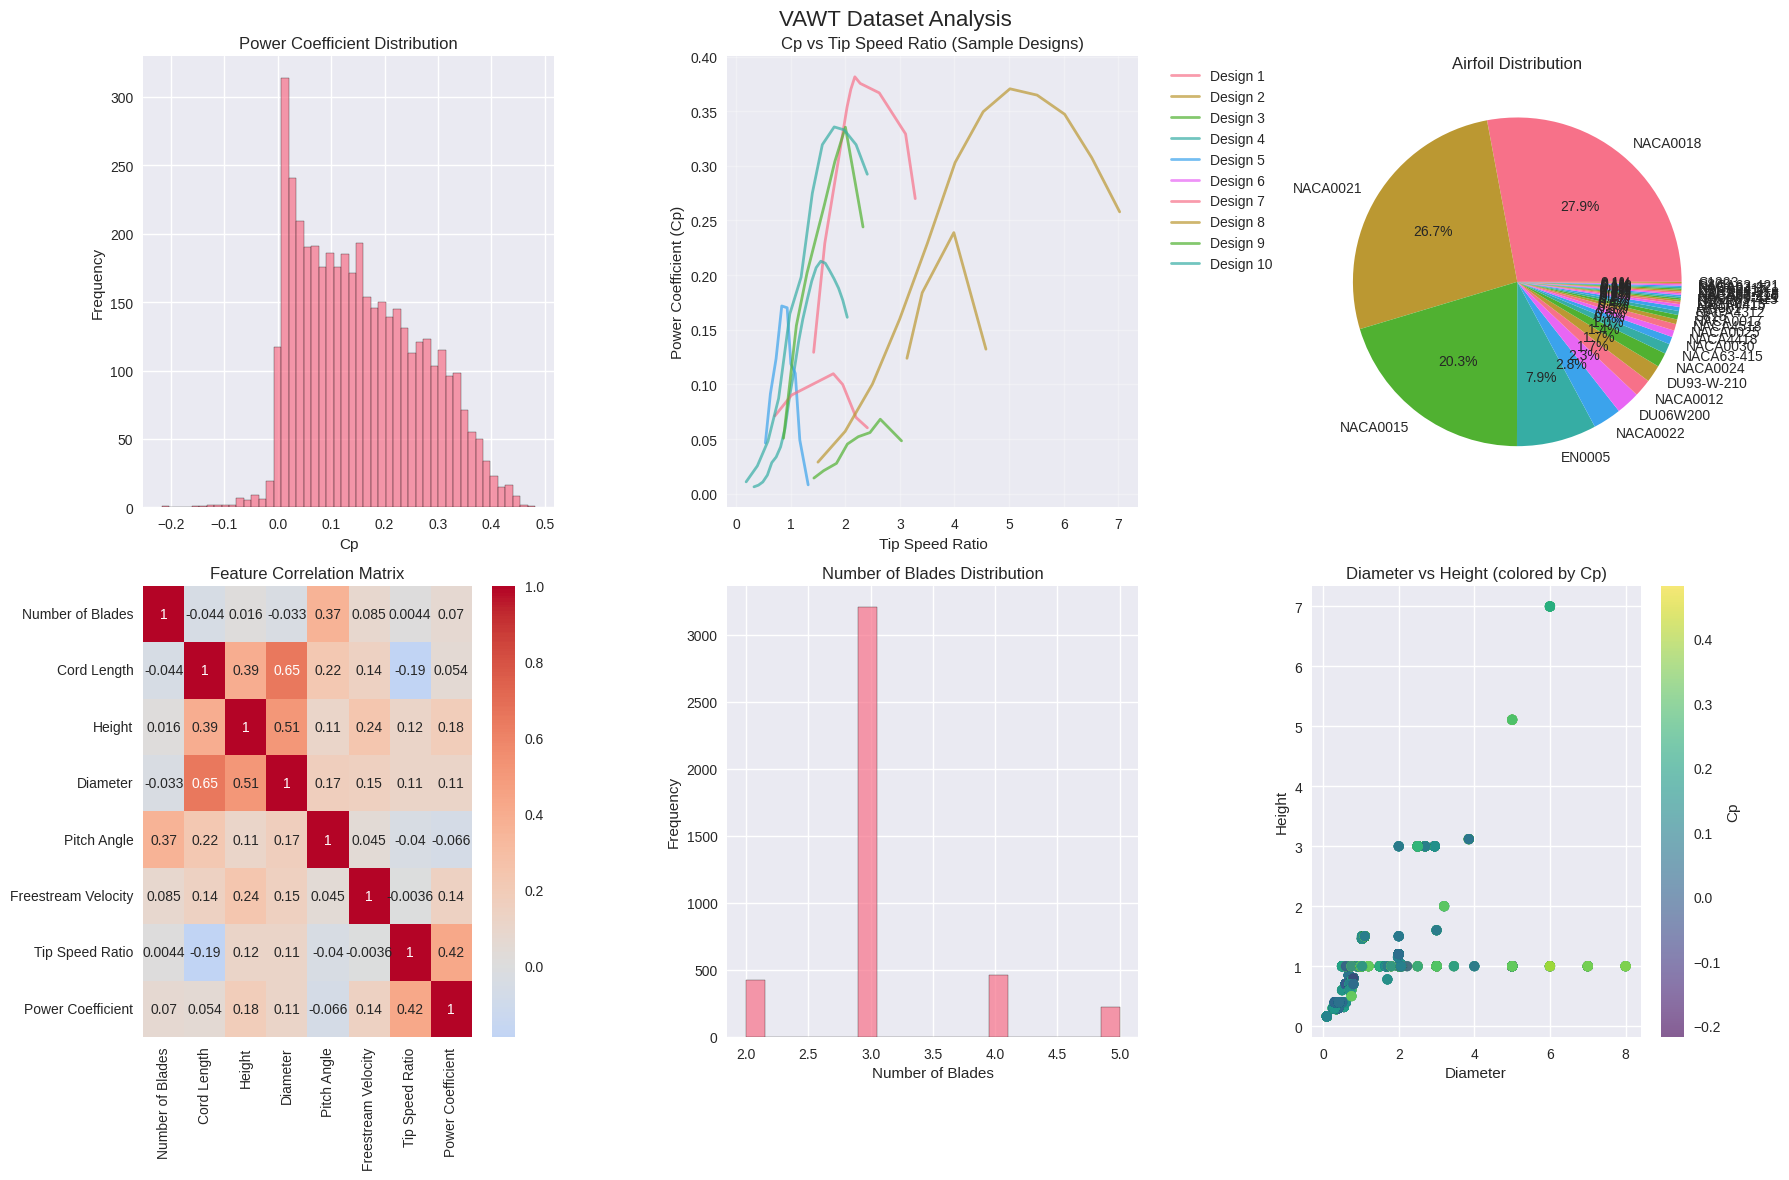


Splitting data...
Training set: 3452 samples
Validation set: 863 samples

Initializing training...
Training on device: cpu
Model parameters: 52,353
Epoch   0: Train Loss = 1.052447, Val Loss = 0.045180, LR = 1.00e-03
Epoch   1: Train Loss = 0.434077, Val Loss = 0.032384, LR = 1.00e-03
Epoch   2: Train Loss = 0.248394, Val Loss = 0.027786, LR = 1.00e-03
Epoch   3: Train Loss = 0.114134, Val Loss = 0.016976, LR = 1.00e-03
Epoch   4: Train Loss = 0.056430, Val Loss = 0.010238, LR = 1.00e-03
Epoch   5: Train Loss = 0.035687, Val Loss = 0.008577, LR = 1.00e-03
Epoch   6: Train Loss = 0.024982, Val Loss = 0.007747, LR = 1.00e-03
Epoch   7: Train Loss = 0.019259, Val Loss = 0.007263, LR = 1.00e-03
Epoch   8: Train Loss = 0.016386, Val Loss = 0.007157, LR = 1.00e-03
Epoch   9: Train Loss = 0.013461, Val Loss = 0.006827, LR = 1.00e-03
Epoch  20: Train Loss = 0.007772, Val Loss = 0.005664, LR = 1.00e-03
Epoch  40: Train Loss = 0.006097, Val Loss = 0.004728, LR = 1.00e-03
Epoch  60: Train Loss =

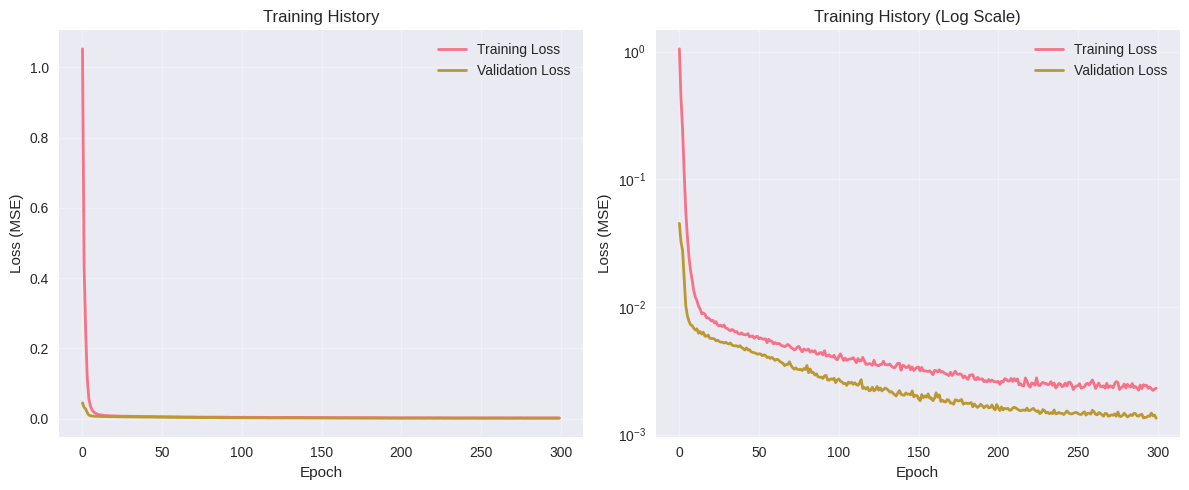


MODEL PERFORMANCE METRICS
R² Score:     0.9220
MSE:          0.000993
RMSE:         0.031512
MAE:          0.022181


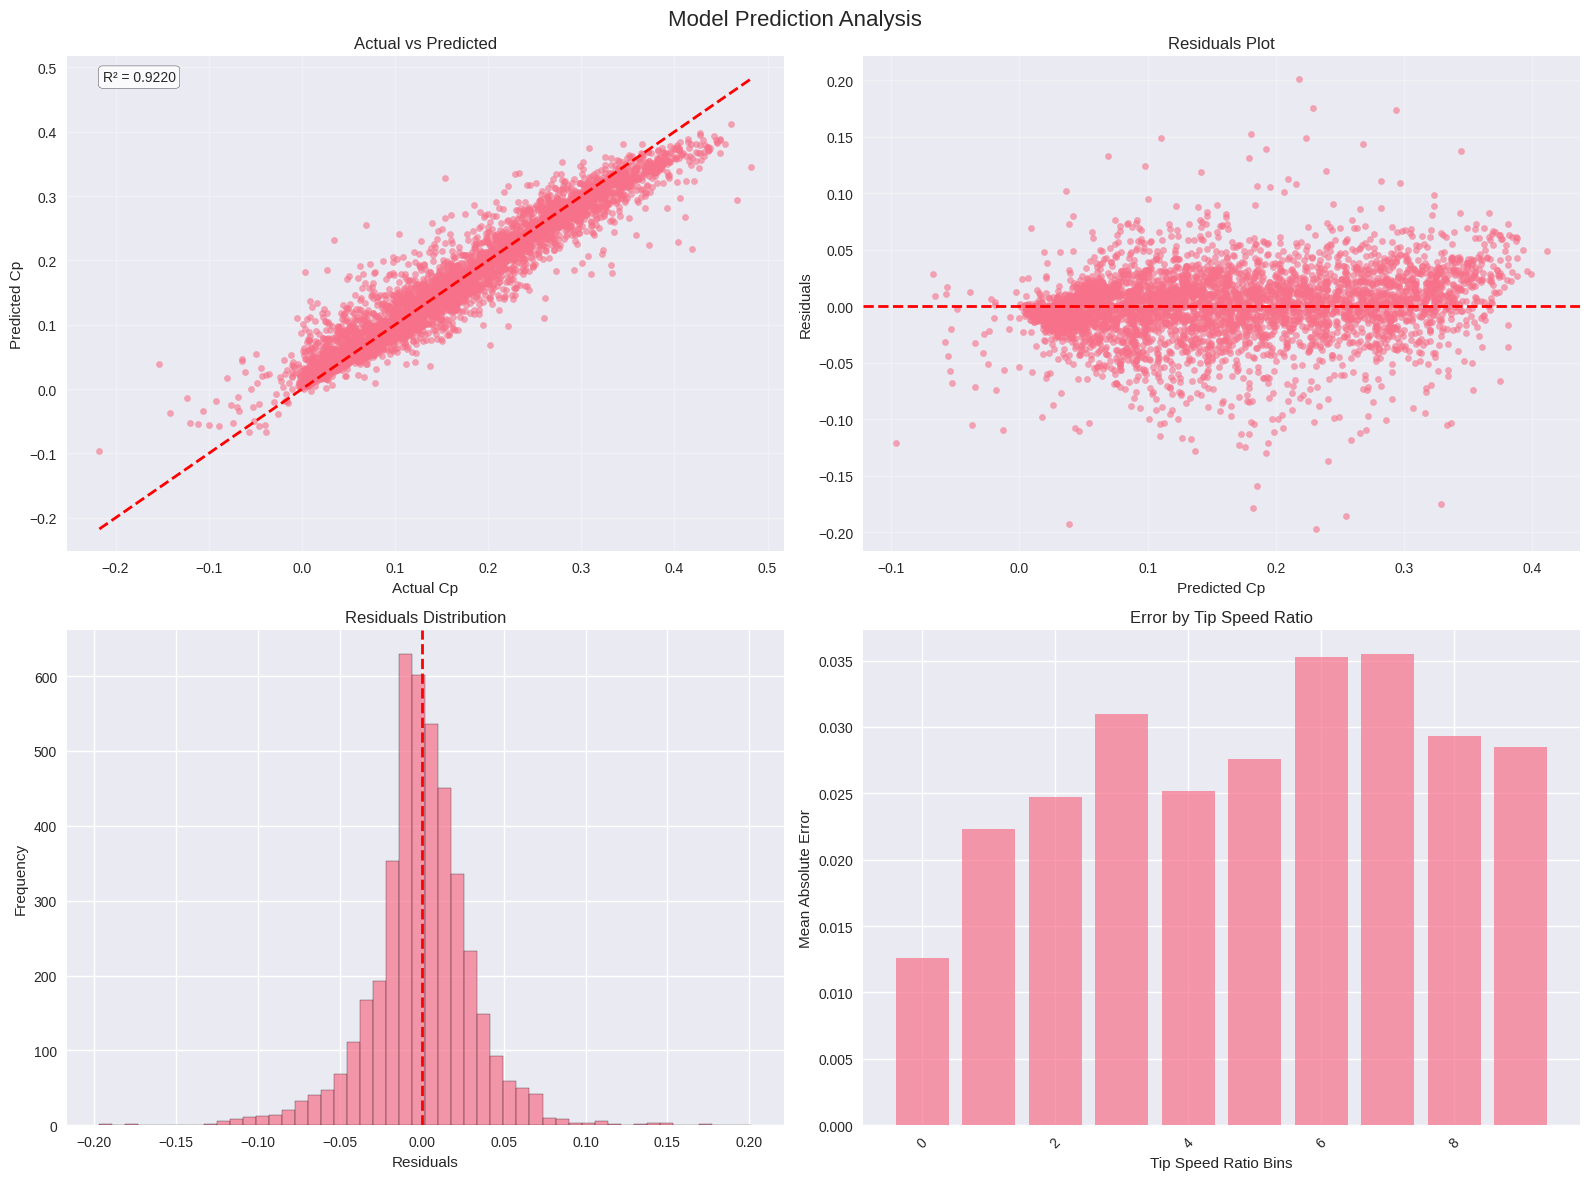

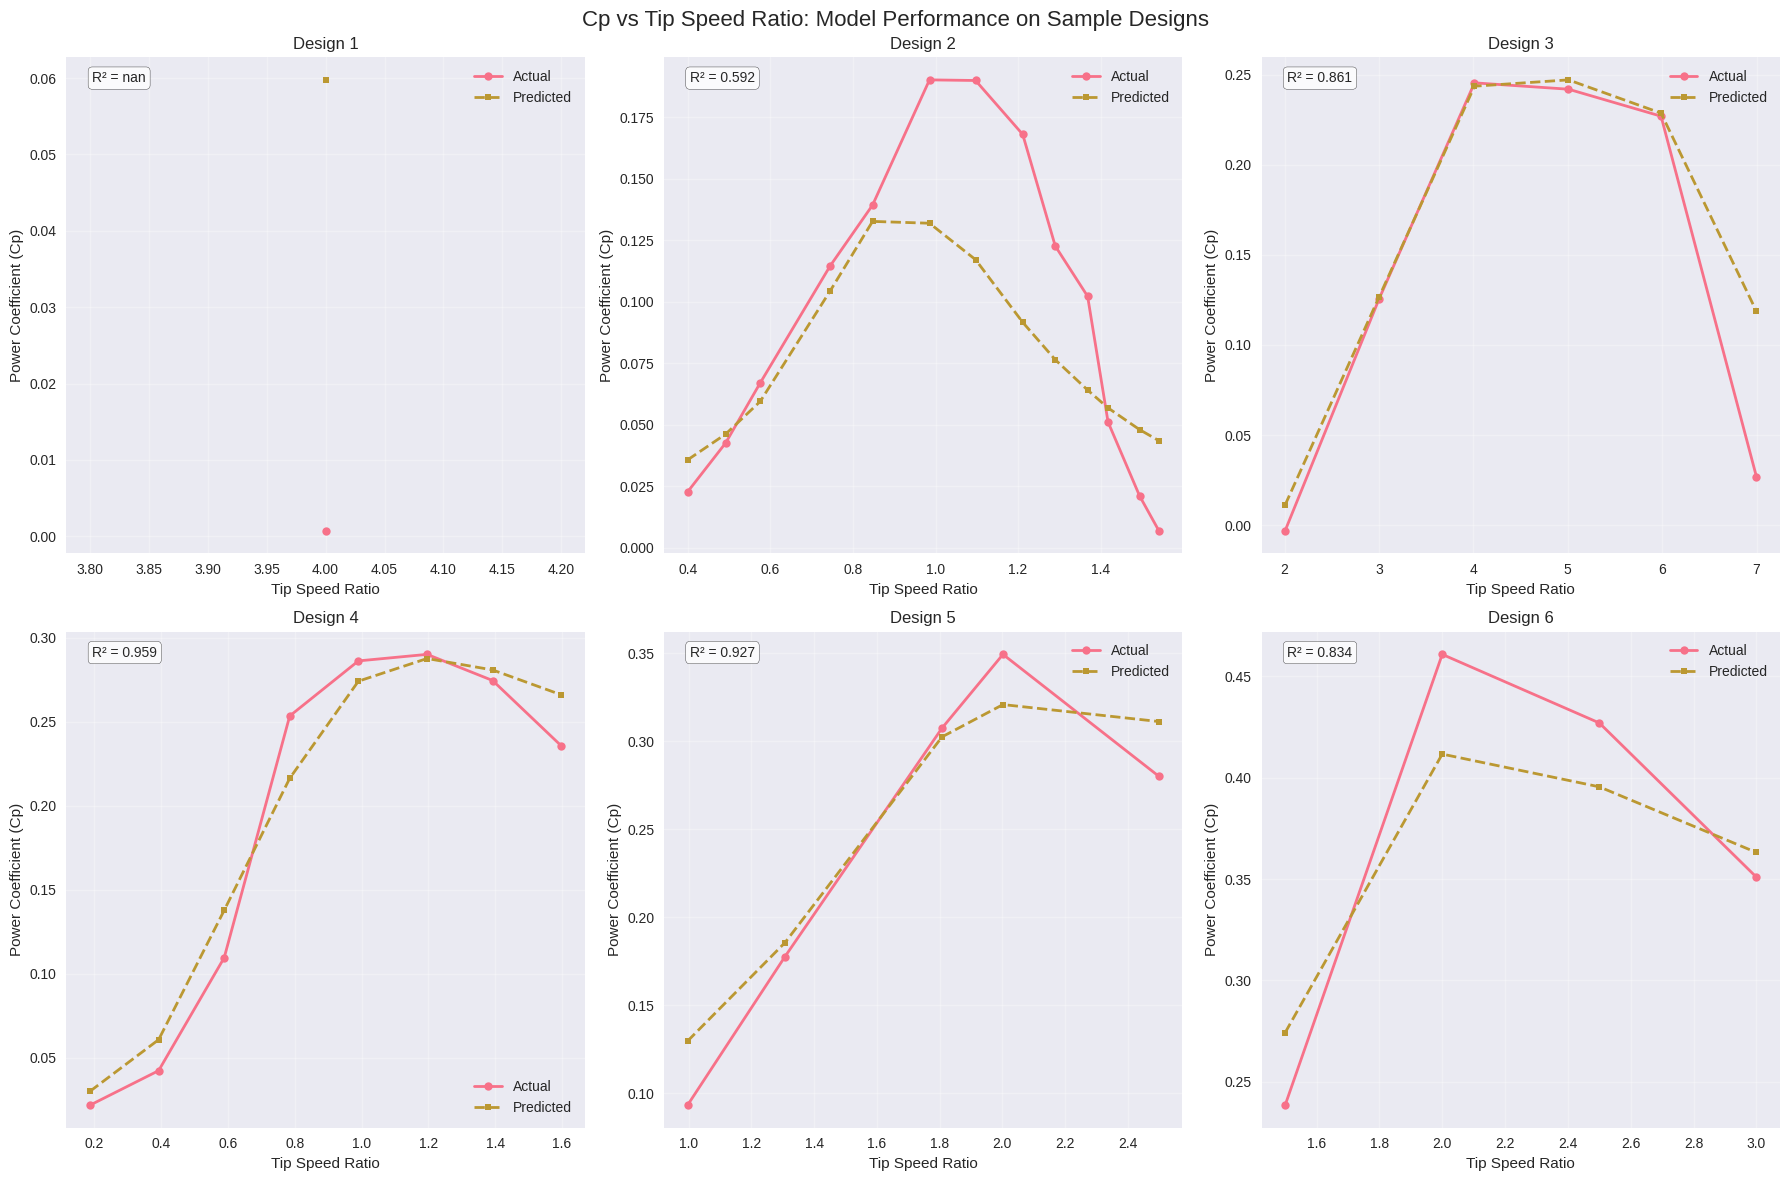


PIPELINE COMPLETED SUCCESSFULLY!


In [7]:
def main():
    """Main pipeline execution"""
    print("="*60)
    print("VERTICAL AXIS WIND TURBINE SURROGATE MODEL")
    print("="*60)

    # Initialize components
    processor = VAWTDataProcessor()

    # Load and preprocess data
    try:
        X, y, df = processor.load_and_preprocess_data('Data.csv')
    except FileNotFoundError:
        print("Error: Data.csv not found. Please upload your dataset.")
        return

    # Visualize data
    print("\nCreating data visualizations...")
    processor.visualize_data_distribution(df)

    # Split data
    print("\nSplitting data...")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=None)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")

    # Create data loaders
    train_dataset = TurbineDataset(X_train, y_train)
    val_dataset = TurbineDataset(X_val, y_val)
    # Add drop_last=True to the training DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    # Initialize model
    input_dim = X.shape[1]
    model = VAWTSurrogateModel(input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3)

    # Train model
    print(f"\nInitializing training...")
    trainer = VAWTTrainer(model)
    train_losses, val_losses = trainer.train_model(train_loader, val_loader,
                                                  epochs=300, lr=0.001, patience=30)

    # Evaluate model
    print("\nEvaluating model...")
    evaluator = VAWTEvaluator(model, processor)

    # Plot training history
    evaluator.plot_training_history(train_losses, val_losses)

    # Full dataset evaluation
    predictions, metrics = evaluator.evaluate_model(X, y, df)

    # Create visualizations
    evaluator.plot_predictions(y, predictions, df)
    evaluator.plot_design_curves(df, predictions, n_designs=6)

    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)

    return model, processor, evaluator, metrics

# Execute the pipeline
if __name__ == '__main__':
    # For Google Colab, uncomment the following lines to install required packages
    # !pip install torch torchvision torchaudio
    # !pip install scikit-learn matplotlib seaborn pandas numpy

    model, processor, evaluator, metrics = main()